In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif # вычисление важности признаков числовых переменных
from sklearn.preprocessing import LabelEncoder # преобразование категориальных в числовые
from sklearn.feature_selection import mutual_info_classif # Для оценки значимости категориальных и бинарных переменных
from sklearn.preprocessing import OneHotEncoder # дамми для np
from sklearn.preprocessing import StandardScaler # преобразуем данные в один масштаб среднее 0, дисп. 1
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from ydata_profiling import ProfileReport # подробный разбор признаков

In [9]:
df0 = pd.read_csv('train-scoring.csv')
df = df0.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [10]:
def test(df, colx):
    # где df - фрейм данных, colx - название анализируемой колонки
    dfx = df[colx]
    a1 = pd.DataFrame(dfx.value_counts()) # создание таблицы с данными по столбцу
    a1['percent'] = round((a1 * 100 / len(df)), 5) # создание таблицы с процентным соотношением данных по столбцу
    b1 = round(abs(len(df) - a1['count'].sum()), 2) # вычисляем количество незаполненных данных
    c1 = round(abs(100 - a1.percent.sum()), 2) # вычисляем процент незаполненных данных
    print(a1), print(f'Количество незаполненных значений: {b1} ~ {c1}%.'), df.loc[:, [colx]].info()
    if dfx.dtypes != 'O': # если столбец числовой, строим гистограмму распределения
        dfx.hist()
def objekt_repeat(df, colx): # функция для замены отсутствующих значений на наиболее часто встречающиеся или,
    # при небольшой разнице в количестве значений, на любое из двух наиболее часто встречающихся.
    # где df - фрейм данных, colx - название анализируемой колонки
    dfx = df[colx]
    a = pd.DataFrame(dfx.value_counts())
    a['percent'] = round((a * 100 / len(df)), 2)
    u = a.percent.values[0] - a.percent.values[1]
    u1 = [a.index[0], a.index[1]]
    if dfx.dtypes == 'O' and u > 15:
    # заполнение строковых столбцов: когда строковые столбцы имеют пропущенные значения и значения NaN
        dfx.fillna(dfx.mode().values[0], inplace = True)
    elif dfx.dtypes == 'O' and u <= 15:
        dfx.fillna(random.choice(u1), inplace = True)
    # заполнение числовых столбцов: когда числовые столбцы имеют пропущенные значения и значения NaN
    elif dfx.dtypes != 'O' and u > 15:
        dfx.fillna(dfx.value_counts().index[0], inplace = True)
    else:
        dfx.fillna(random.choice(u1), inplace = True)
    b = pd.DataFrame(dfx.value_counts()) # создание таблицы с данными по столбцу
    b['percent'] = round((b * 100 / len(df)), 2) # создание таблицы с процентным соотношением данных по столбцу
    return b

<Axes: >

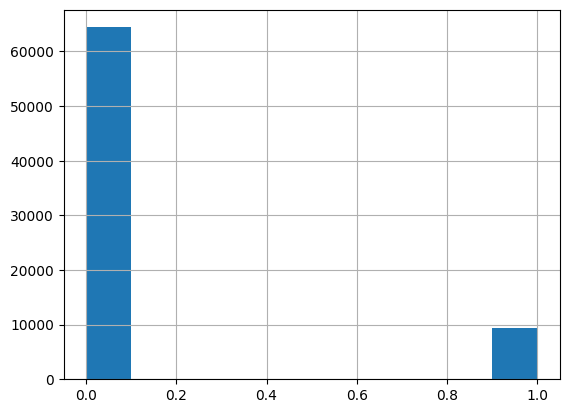

In [11]:
# Постройте диаграмму для переменной default . Каких клиентов у банка больше?
df.default.hist()

In [12]:
# проверим столбец на распределение данных
test(df, 'education')

           count   percent
education                 
SCH        38860  52.65654
GRD        23365  31.66032
UGR         9816  13.30099
PGR         1257   1.70328
ACD          194   0.26288
Количество незаполненных значений: 307 ~ 0.42%.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   education  73492 non-null  object
dtypes: object(1)
memory usage: 576.7+ KB


In [13]:
# заменим отсутствующие значения на наиболее часто встречающиеся или,
# при небольшой разнице в количестве значений, на любое из двух наиболее часто встречающихся.
objekt_repeat(df, 'education')

,count,percent
education,,
SCH,39167,53.07
GRD,23365,31.66
UGR,9816,13.30
PGR,1257,1.70
ACD,194,0.26


<Figure size 640x480 with 0 Axes>

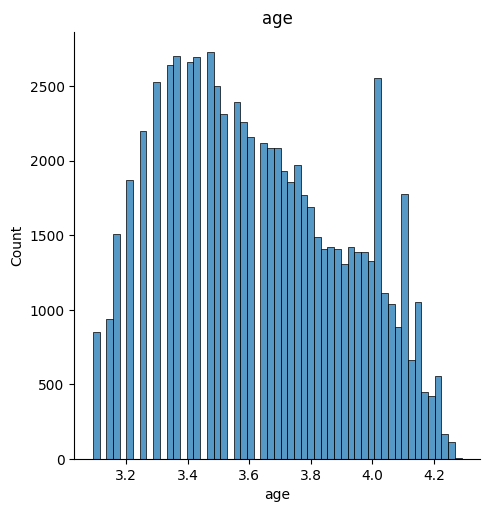

<Figure size 640x480 with 0 Axes>

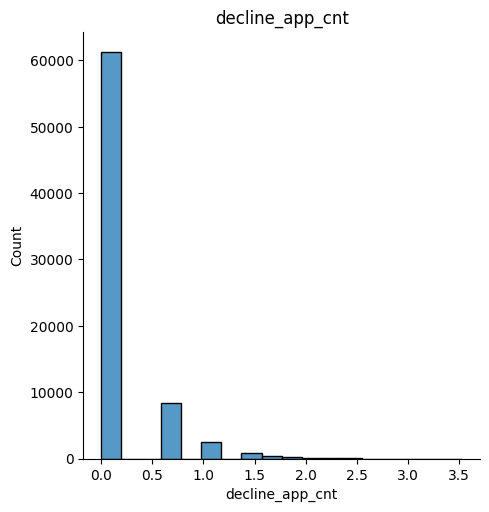

<Figure size 640x480 with 0 Axes>

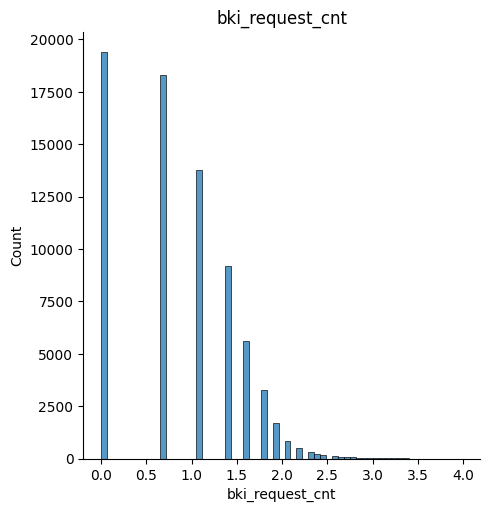

<Figure size 640x480 with 0 Axes>

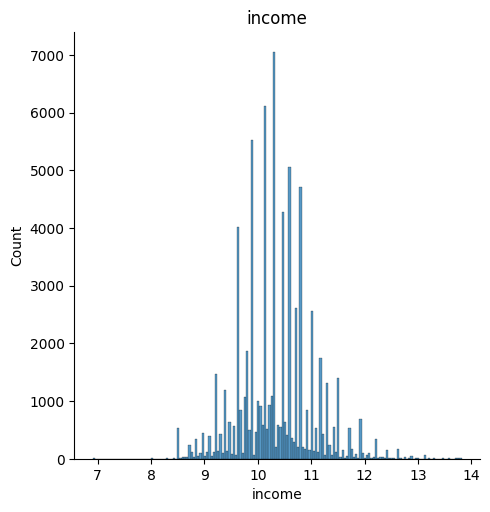

In [14]:
#бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
#категориальные переменные
cat_cols = ['education', 'work_address', 'home_address']
#числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for i in num_cols:
    plt.figure()
    sns.displot(np.log(df[i]+1), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [15]:
df.default.value_counts()

default
0    64427
1     9372
Name: count, dtype: int64

39.3905039812501 38.52539479300043


<Axes: ylabel='age'>

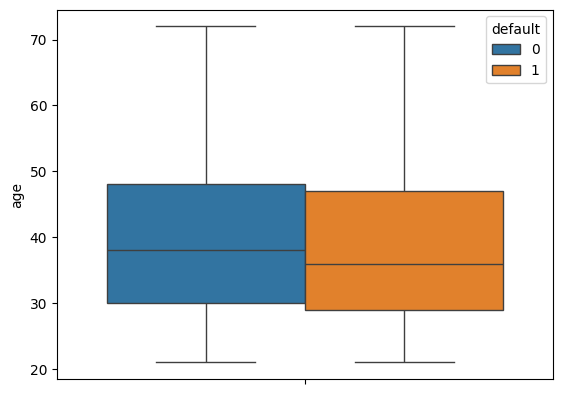

In [16]:
# Дефолтные клиенты в среднем по возрасту
print(df.age[df.default==0].mean(), df.age[df.default==1].mean())
sns.boxplot(y= 'age', data = df, hue = 'default')

0.2408772719512006 0.5154716175842936


<Axes: ylabel='decline_app_cnt'>

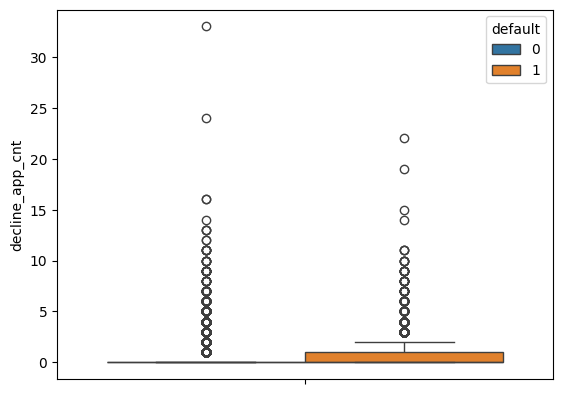

In [17]:
# Дефолтные клиенты в среднем имеют ... количество отмененных заявок
print(df.decline_app_cnt[df.default==0].mean(), df.decline_app_cnt[df.default==1].mean())
sns.boxplot(y= 'decline_app_cnt', data = df, hue = 'default')

1.9331336241016965 2.4623346137430646


<Axes: ylabel='bki_request_cnt'>

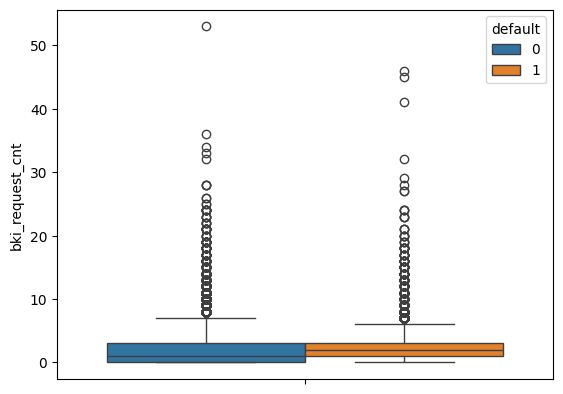

In [18]:
# Дефолтные клиенты в среднем имеют ... запросов в БКИ
print(df.bki_request_cnt[df.default==0].mean(), df.bki_request_cnt[df.default==1].mean())
sns.boxplot(y= 'bki_request_cnt', data = df, hue = 'default')

41799.713287907245 36288.1133162612


<Axes: ylabel='income'>

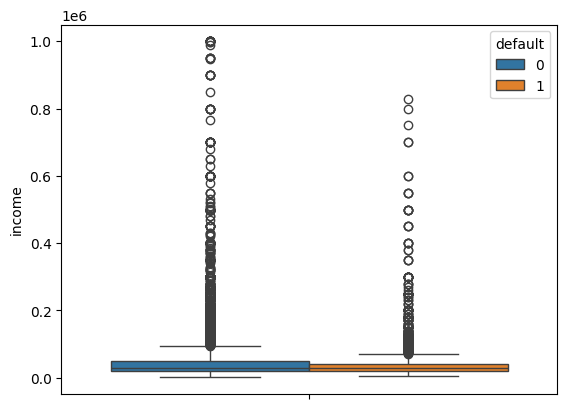

In [19]:
# Дефолтные клиенты в среднем имеют более ... доход
print(df.income[df.default==0].mean(), df.income[df.default==1].mean())
sns.boxplot(y= 'income', data = df, hue = 'default')

<Axes: >

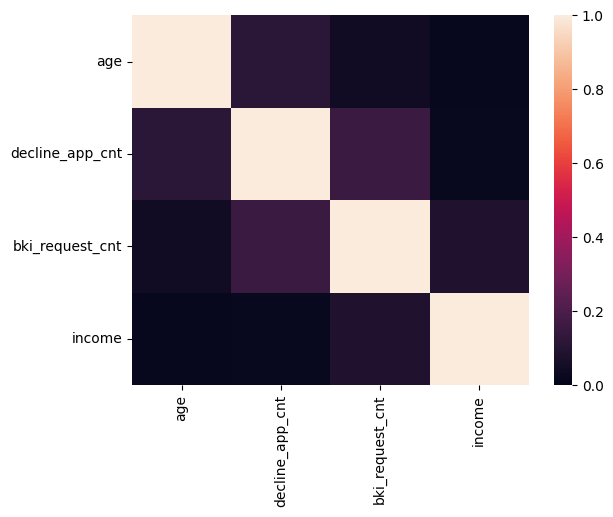

In [20]:
#числовые переменные ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

In [21]:
df[num_cols].corr().abs()

,age,decline_app_cnt,bki_request_cnt,income
age,1.000000,0.111175,0.046265,0.018900
decline_app_cnt,0.111175,1.000000,0.155894,0.021687
bki_request_cnt,0.046265,0.155894,1.000000,0.082983
income,0.018900,0.021687,0.082983,1.000000


<Axes: >

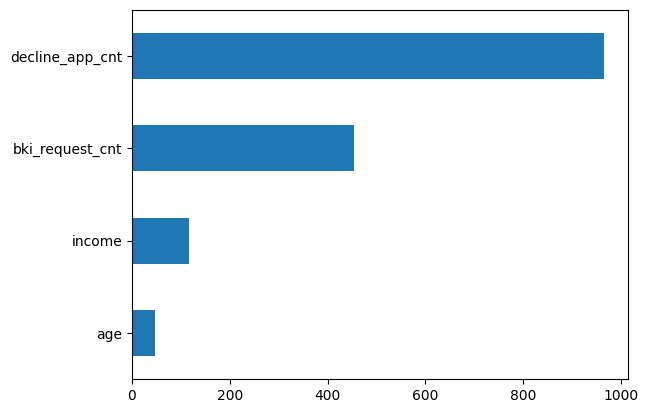

In [22]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [23]:
# Найдём самый значимый признак
pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)

age                 46.166168
decline_app_cnt    966.206975
bki_request_cnt    454.555786
income             116.798014
dtype: float64

In [24]:
# образец преобразования категориальных в числовые
label_encoder = LabelEncoder()
mapped_education = pd.Series(label_encoder.fit_transform(df['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [25]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
# убедимся в преобразовании
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,SCH,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,SCH,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,SCH,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,GRD,1,48,0,0,0,1,1,2,3,30000,1,0


In [26]:
# преобразуем колонку образования в категории.
label_encoder = LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])
# убедимся в преобразовании
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,3,1,62,1,1,0,0,1,1,2,18000,0,0
1,63161,3,0,59,0,0,0,0,3,2,3,19000,0,0
2,25887,3,1,25,1,0,2,0,1,1,2,30000,1,0
3,16222,3,0,53,0,0,0,0,2,2,3,10000,0,0
4,101655,1,1,48,0,0,0,1,1,2,3,30000,1,0


<Axes: >

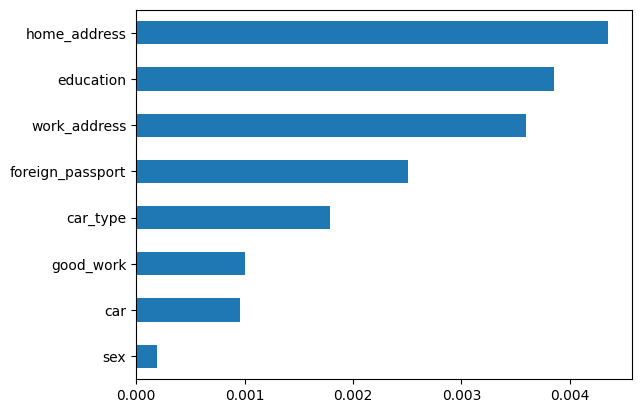

In [27]:
#бинарные переменные ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
#категориальные переменные ['education', 'work_address', 'home_address']
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'], discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [28]:
mutual_info_classif(df[bin_cols + cat_cols], df['default'], discrete_features =True)

array([0.0001918 , 0.00095689, 0.00178806, 0.001004  , 0.00250796,
       0.00385746, 0.00359125, 0.00435616])

In [29]:
df.default.value_counts()

default
0    64427
1     9372
Name: count, dtype: int64

In [30]:
#категориальные переменные ['education', 'work_address', 'home_address']
# OneHotEncoder преобразует данные в разреженную матрицу
X_cat = OneHotEncoder(sparse_output= False).fit_transform(df[cat_cols].values)

In [31]:
X_cat.shape

(73799, 11)

In [32]:
df1 = pd.DataFrame(X_cat[:, -1])
df1.value_counts()

0.0    72541
1.0     1258
Name: count, dtype: int64

In [33]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(df[num_cols].values)

In [34]:
#бинарные переменные ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
#категориальные переменные ['education', 'work_address', 'home_address']
# разобъём данные на тренировочные и валидационные
# бинарные и закодированные категориальные переменные в одно признаковое пространство
default = np.atleast_2d(df.default.to_numpy()).T
data = np.hstack([X_num, df[bin_cols].values, X_cat, default])
X_train, X_val, y_train, y_val = train_test_split(data[:, :-1], data[:, -1], test_size=0.33, random_state=42, stratify=data[:, -1])

In [35]:
# Обучим модель на стандартных настройках логистической регрессии.
# Используйте обученную модель для предсказания дефолта в validation-выборке.
# Запишите предсказанные значения в переменную y_pred =model.predict_proba().
model = LogisticRegression(max_iter=4000, random_state=42)
model.fit(X_train, y_train)
y_pred =model.predict_proba(X_val)
print(model.score(X_train, y_train))
print(model.score(X_val, y_val))
print(confusion_matrix(y_val, model.predict(X_val)))

0.8724239053493781
0.8729161534039582
[[21235    26]
 [ 3069    24]]


In [36]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model1 = LogisticRegression()
iter_ = 4000
epsilon_stop = 1e-3
param_grid = [
{'C': [0.0001, 0.01, 0.1, 1, 10],
'penalty': ['l1'],
'solver': ['liblinear', 'lbfgs'],
'class_weight':['none', 'balanced'],
'multi_class': ['auto','ovr'],
'max_iter':[iter_],
'tol':[epsilon_stop]},
{'C': [0.0001, 0.01, 0.1, 1, 10],
'penalty': ['l2'],
'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
'class_weight':['none', 'balanced'],
'multi_class': ['auto','ovr'],
'max_iter':[iter_],
'tol':[epsilon_stop]},
{'C': [0.0001, 0.01, 0.1, 1, 10],
'penalty': ['none'],
'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
'class_weight':['none', 'balanced'],
'multi_class': ['auto','ovr'],
'max_iter':[iter_],
'tol':[epsilon_stop]},
]
## model ваша модель логистической регрессии
gridsearch = GridSearchCV(model1, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model1 = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model1.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
600 fits failed out of a total of 1100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
550 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\ProgramData\anaconda3\Lib\site-packa

KeyboardInterrupt: 

In [ ]:
# Обучим модель на новых настройках логистической регрессии.
# Используйте обученную модель для предсказания дефолта в validation-выборке.
# Запишите предсказанные значения в переменную y_pred =model.predict_proba().
y_pred =model1.predict_proba(X_val)
print(model1.score(X_train, y_train))
print(model1.score(X_val, y_val))
print(f1_score(y_val,  model1.predict(X_val)))
print(confusion_matrix(y_val, model1.predict(X_val)))
print(classification_report(y_val, model1.predict(X_val)))

In [ ]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model2 = RandomForestClassifier()
param_grid2 = [
{'n_estimators': [1, 5, 10, 100],
'max_depth': [1, 3, 5, 7, 10, 15, 50, 100]}
]
## model ваша модель логистической регрессии
gridsearch2 = GridSearchCV(model2, param_grid2, scoring='f1', n_jobs=-1, cv=5)
gridsearch2.fit(X_train, y_train)
model2 = gridsearch2.best_estimator_
##печатаем параметры
best_parameters2 = model2.get_params()
for param_name in sorted(best_parameters2.keys()):
    print('\t%s: %r' % (param_name, best_parameters2[param_name]))

In [ ]:
y_pred =model2.predict_proba(X_val)
print(model2.score(X_train, y_train))
print(model2.score(X_val, y_val))
print(f1_score(y_val,  model2.predict(X_val)))
print(confusion_matrix(y_val, model2.predict(X_val)))
print(classification_report(y_val, model2.predict(X_val)))

In [ ]:
0.8724239053493781
0.8729161534039582
[[21235    26]
 [ 3069    24]]

0.6102942663565578
0.6120144534778681
[[12969  8292]
 [ 1157  1936]]

# Автоматический анализ датасета

In [38]:
ProfileReport(df, title='My Data')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]